# KoSAIM 2024 개발자를 위한 의료 AI 심화교육 II

## LLM finetuning with Healthcare data

- 강사: 배성수(seongsu@kaist.ac.kr), 임수정(sujeongim@kaist.ac.kr)

- 발표자료: https://docs.google.com/presentation/d/1Pw1h1F_4kYSF2GGkDhtPE-R29Cvycd5xs4koFec0bmQ/edit?usp=sharing

- 레퍼런스: https://github.com/starmpcc/KAIA-LLM-FT-2024

## [Step 1] 환경 세팅

### 패키지 설치

In [1]:
!pip install -q accelerate==0.33.0 peft==0.6.2 bitsandbytes==0.43.3 transformers==4.41 trl==0.9.2 einops gradio nltk

### 라이브러리 가져오기
- `datasets`: https://github.com/huggingface/datasets/tree/3.1.0
- `transformers`: https://github.com/huggingface/transformers
- `accelerate`: https://github.com/huggingface/accelerate
- `peft`: https://github.com/huggingface/peft
- `trl`: https://github.com/huggingface/trl

In [2]:
import os
import torch
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# huggingface
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
import gradio as gr

import warnings
warnings.filterwarnings('ignore')

## [Step 2] 사전 학습된 모델 (및 토크나이저) 불러오기

### 모델 가져오기

In [61]:
# Quantization Config 정의
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

# 사전학습된 기본 모델 가져오기
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto",
    force_download=True,
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### 모델 살펴보기

In [4]:
# (양자화된) 레이어 살펴보기
model.model.layers[0].mlp.fc1.weight

Parameter containing:
Parameter(Params4bit([[ 28],
            [209],
            [203],
            ...,
            [ 48],
            [204],
            [ 84]], device='cuda:0', dtype=torch.uint8))

In [5]:
# (양자회된) 레이어 데이터 타입 살펴보기
model.model.layers[0].mlp.fc1.weight.dtype

torch.uint8

In [6]:
# 모델 파라미터 개수 확인
sum([p.numel() for p in model.parameters()])

1521392640

In [7]:
# cuda memory 체크
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1859 MiB |   1887 MiB |   6660 MiB |   4800 MiB |
|       from large pool |   1800 MiB |   1837 MiB |   6600 MiB |   4800 MiB |
|       from small pool |     59 MiB |     59 MiB |     60 MiB |      0 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1859 MiB |   1887 MiB |   6660 MiB |   4800 MiB |
|       from large pool |   1800 MiB |   1837 MiB |   6600 MiB |

### 토크나이저 가져오기

In [8]:
# 모델에 맞는 토크나이저 가져오기
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_sight = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 토크나이저 살펴보기

In [9]:
# tokenizer vocab 개수 확인
len(tokenizer.vocab)

50295

In [10]:
# tokenizer vocab 확인
tokenizer.vocab

{'Ġchili': 32728,
 'ĠPL': 9297,
 'ĠUtt': 36057,
 'Super': 12442,
 'Ġbour': 38043,
 'ĠPublications': 40865,
 'ĠUI': 12454,
 'roman': 47119,
 'Ġmercury': 27394,
 'ĠkHz': 37597,
 'Ġdat': 4818,
 'Parent': 24546,
 'Ġblush': 37854,
 'ito': 10094,
 'Ġfunc': 25439,
 'ĠOy': 39447,
 'Ġprojector': 43396,
 'Ġeyebrows': 26928,
 'Ġstorefront': 45527,
 'ĠPittsburgh': 12767,
 'ĠLevy': 32036,
 'Ġpredominantly': 20736,
 'ĠNope': 39544,
 'Ġbombed': 34221,
 '206': 22136,
 'abit': 29968,
 'Ġmaturity': 24841,
 'Ġcoun': 2289,
 'ordinary': 35947,
 'ĠDrupal': 40452,
 'Ġwrapped': 12908,
 'Ġpunk': 22782,
 'rel': 2411,
 'Ġmight': 1244,
 'ĠReact': 21492,
 '");': 15341,
 'Ġreson': 14309,
 'Ġinaugural': 26851,
 'Ġrunes': 32326,
 'Ġcores': 21758,
 'Ġdefinitely': 4753,
 'Russ': 10020,
 'Ġextravagant': 45997,
 'Ġasylum': 13142,
 'ĠRBI': 20948,
 'claim': 6604,
 'Too': 23307,
 'Ġknowledge': 3725,
 'iser': 5847,
 'ja': 6592,
 'Ġpacked': 11856,
 'Ġgad': 23793,
 'estine': 27374,
 'Ġforeground': 36282,
 'rous': 7596,
 'ĠCost

In [11]:
# tokenizer special token 확인
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [12]:
# tokenizer로 tokenize 해보기
tokenizer.tokenize("Hi, my name is John.")

['Hi', ',', 'Ġmy', 'Ġname', 'Ġis', 'ĠJohn', '.']

In [13]:
# tokenizer로 encoding 해보기
tokenizer.encode("Hi, my name is John.")

[17250, 11, 616, 1438, 318, 1757, 13]

In [14]:
# tokenizer로 encoding 해보기 (2)
tokenizer("Hi, my name is John.")

{'input_ids': [17250, 11, 616, 1438, 318, 1757, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [15]:
# encode_plus
tokenizer.encode_plus("Hi, my name is John.")

{'input_ids': [17250, 11, 616, 1438, 318, 1757, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [16]:
# tokenizer로 encoding -> decoding 해보기
sample_text = "Hi, my name is John."
encoded_text = tokenizer.encode(sample_text)
decoded_text = tokenizer.decode(encoded_text)
print(decoded_text)

Hi, my name is John.


In [17]:
# batch-wise tokenize
sample_text_list = [
    "Hi, my name is John.",
    "Hi, my name is Mike.",
    "Hi, my name is Anna.",
    "Hi, my name is Julia.",
]
tokenizer(sample_text_list)

{'input_ids': [[17250, 11, 616, 1438, 318, 1757, 13], [17250, 11, 616, 1438, 318, 4995, 13], [17250, 11, 616, 1438, 318, 11735, 13], [17250, 11, 616, 1438, 318, 22300, 13]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

In [18]:
# batch_encode_plus
sample_text_list = [
    "Hi, my name is John.",
    "Hi, my name is Mike.",
    "Hi, my name is Anna.",
    "Hi, my name is Julia.",
]
tokenizer.batch_encode_plus(sample_text_list)

{'input_ids': [[17250, 11, 616, 1438, 318, 1757, 13], [17250, 11, 616, 1438, 318, 4995, 13], [17250, 11, 616, 1438, 318, 11735, 13], [17250, 11, 616, 1438, 318, 22300, 13]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

## [Step 3] Asclepius-Synthetic-Clinical-Notes 데이터셋 확인하기

- 데이터 링크 : https://huggingface.co/datasets/starmpcc/Asclepius-Synthetic-Clinical-Notes


### 데이터 불러오기

In [19]:
# Asclepius-Synthetic-Clinical-Notes 원본 데이터셋 가져오기
dataset = load_dataset("starmpcc/Asclepius-Synthetic-Clinical-Notes")

In [20]:
# 데이터셋 체크
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'note', 'question', 'answer', 'task'],
        num_rows: 158114
    })
})

In [21]:
dataset.keys()

dict_keys(['train'])

In [22]:
dataset['train'][0]

{'patient_id': 0,
 'note': "Discharge Summary:\n\nPatient: 60-year-old male with moderate ARDS from COVID-19\n\nHospital Course:\n\nThe patient was admitted to the hospital with symptoms of fever, dry cough, and dyspnea. During physical therapy on the acute ward, the patient experienced coughing attacks that induced oxygen desaturation and dyspnea with any change of position or deep breathing. To avoid rapid deterioration and respiratory failure, a step-by-step approach was used for position changes. The breathing exercises were adapted to avoid prolonged coughing and oxygen desaturation, and with close monitoring, the patient managed to perform strength and walking exercises at a low level. Exercise progression was low initially but increased daily until hospital discharge to a rehabilitation clinic on day 10.\n\nClinical Outcome:\n\nThe patient was discharged on day 10 to a rehabilitation clinic making satisfactory progress with all symptoms resolved.\n\nFollow-up:\n\nThe patient wil

In [23]:
print(dataset['train'][0]['note'])

Discharge Summary:

Patient: 60-year-old male with moderate ARDS from COVID-19

Hospital Course:

The patient was admitted to the hospital with symptoms of fever, dry cough, and dyspnea. During physical therapy on the acute ward, the patient experienced coughing attacks that induced oxygen desaturation and dyspnea with any change of position or deep breathing. To avoid rapid deterioration and respiratory failure, a step-by-step approach was used for position changes. The breathing exercises were adapted to avoid prolonged coughing and oxygen desaturation, and with close monitoring, the patient managed to perform strength and walking exercises at a low level. Exercise progression was low initially but increased daily until hospital discharge to a rehabilitation clinic on day 10.

Clinical Outcome:

The patient was discharged on day 10 to a rehabilitation clinic making satisfactory progress with all symptoms resolved.

Follow-up:

The patient will receive follow-up care at the rehabilita

In [24]:
# 필터링: 노트의 길이가 1500보다 작은 경우
dataset = dataset.filter(lambda x: [len(i)<1500 for i in x['note']], batched=True)

In [25]:
# 데이터셋 체크 (필터링 이후)
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'note', 'question', 'answer', 'task'],
        num_rows: 36654
    })
})

In [26]:
# 필터링 함수 정의
def prompt_shorter_than(samples):
    # 각 샘플의 'note', 'question', 'answer' 필드를 공백으로 연결하여 하나의 문자열로 결합
    concatenated = [" ".join([i, j, k]) for i, j, k in zip(samples['note'], samples['question'], samples['answer'])]
    # 결합된 문자열을 토크나이저로 토큰화하고, 토큰 길이가 320 이하인지를 확인하여 리스트로 반환
    return [len(i)<=320 for i in tokenizer(concatenated)['input_ids']]

In [27]:
# 필터링: 토크나이저
dataset = dataset.filter(prompt_shorter_than, batched=True)

In [28]:
# 데이터셋 체크 (필터링 이후)
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'note', 'question', 'answer', 'task'],
        num_rows: 3686
    })
})

### 데이터 탐색하기

In [29]:
# train 데이터 구성
print(dataset['train'])
print()

Dataset({
    features: ['patient_id', 'note', 'question', 'answer', 'task'],
    num_rows: 3686
})



In [30]:
# 샘플 데이터 확인
sample_idx = 0
sample_data = dataset['train'][sample_idx]
sample_data

{'patient_id': 110,
 'note': "Hospital Course:\n\nThe patient, who was involved in a murder case, was admitted to our forensic facility for toxicology testing and a complete neuropsychiatric evaluation. The case is complicated due to the defendant's claimed genetic predisposition to anti-social behavior and his regular consumption of alcohol and drugs since the beginning of adolescence.\n\nToxicology testing revealed detectable levels of benzoylecgonine in urine and pubic hair, while blood and saliva samples showed no significant levels of drugs or alcohol. A full clinical and neuropsychological examination was performed, which identified a personality disorder not otherwise specified. MRI imaging showed a decrease in cortical thickness with enlarged lateral ventricles, significant volumetric asymmetry of the amygdalae, and a decreased volume of the right orbito-frontal cortex in comparison with the left one. PET-CT testing did not indicate any alteration of brain perfusion or metaboli

In [31]:
# 데이터셋을 DataFrame으로 변환
df = pd.DataFrame(dataset['train'])

# 데이터프레임 일부 출력(5개만 출력)
df.head(5)

,patient_id,note,question,answer,task
0,110,"Hospital Course:\n\nThe patient, who was invol...",What are the detectable levels of benzoylecgon...,Detectable levels of benzoylecgonine were foun...,Temporal Information Extraction
1,156,Hospital Course: \nThe patient was admitted to...,"At what dosage was topiramate increased to, an...",The topiramate was increased to 100 mg total d...,Temporal Information Extraction
2,174,Hospital Course:\n42-year-old male presented t...,What was the emergency laparoscopic surgery pe...,The emergency laparoscopic surgery performed o...,Question Answering
3,336,Discharge Summary\n\nAdmission Date: N/A\nDisc...,What was the reason for the patient's elevated...,The patient had elevated creatinine levels due...,Temporal Information Extraction
4,371,Hospital Course:\nA 31-year-old Saudi male pre...,What is the relationship between the patient's...,The patient's tobacco use was determined to be...,Relation Extraction


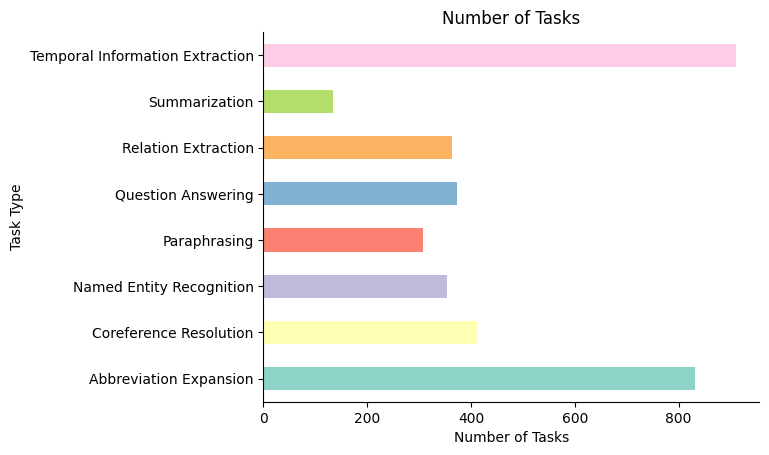

In [32]:
# Task 종류별 개수
df.groupby('task').size().plot(kind='barh', color=plt.cm.Set3.colors)
plt.xlabel('Number of Tasks')
plt.ylabel('Task Type')
plt.title('Number of Tasks')
plt.gca().spines[['top', 'right',]].set_visible(False)

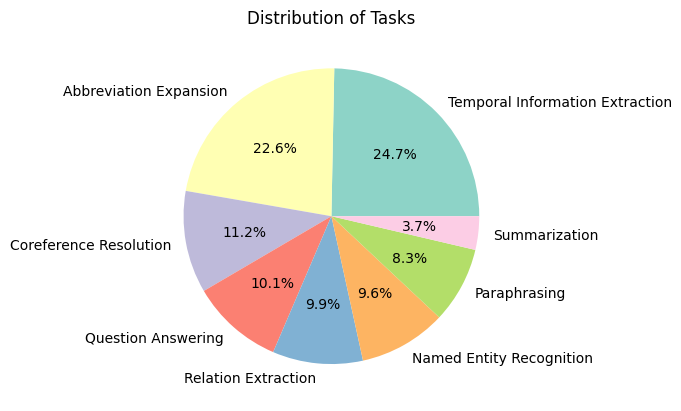

In [33]:
# Task 분포
df['task'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Set3.colors)
plt.ylabel('')
plt.title('Distribution of Tasks')
plt.show()

## [Step 4] 학습 데이터 전처리

### 프롬프트 데이터 전처리 함수 정의 (`formatting_func`)

In [34]:
# 해당 프롬프트 포맷은 phi-2 모델에 사용 가능
# Phi-2 instruction-answer format: "Instruct: <prompt>\nOutput:"

prompt_template="""Instruct: Answer to the question for the given clinical note.
[note start]
{note}
[note end]

Question: {question}

Output: {answer}"""

In [35]:
print(prompt_template.format(note="xxx", question="yyy", answer="zzz"))

Instruct: Answer to the question for the given clinical note.
[note start]
xxx
[note end]

Question: yyy

Output: zzz


In [36]:
# 샘플 데이터를 입력으로 받아 형식에 맞게 프롬프트를 구성하여 내보내는 함수
def format_dataset(samples):
    outputs = []
    for _, note, question, answer, _ in zip(*samples.values()):
        out = prompt_template.format(note=note, question=question, answer=answer)
        outputs.append(out)
    return outputs

sample_input = format_dataset({k: [v] for k, v in dataset['train'][0].items()})[0]
print(sample_input)

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

The patient, who was involved in a murder case, was admitted to our forensic facility for toxicology testing and a complete neuropsychiatric evaluation. The case is complicated due to the defendant's claimed genetic predisposition to anti-social behavior and his regular consumption of alcohol and drugs since the beginning of adolescence.

Toxicology testing revealed detectable levels of benzoylecgonine in urine and pubic hair, while blood and saliva samples showed no significant levels of drugs or alcohol. A full clinical and neuropsychological examination was performed, which identified a personality disorder not otherwise specified. MRI imaging showed a decrease in cortical thickness with enlarged lateral ventricles, significant volumetric asymmetry of the amygdalae, and a decreased volume of the right orbito-frontal cortex in comparison with the left one. PET-CT testing did not indicate any 

In [37]:
# Sanity Check
prompt_len = len(tokenizer.encode(prompt_template))
if prompt_len > 180:
    raise ValueError(f"Your prompt is too long! Please reduce the length from {prompt_len} to 180 tokens")
print(f"Prompt Length: {prompt_len} tokens")

Prompt Length: 40 tokens


### 프롬프트 데이터 입출력 확인

In [38]:
# 샘플 프롬프트 데이터 생성
sample_idx = 10
sample_data = dataset['train'][sample_idx]
sample_fmt_data = format_dataset({k: [v] for k, v in sample_data.items()})
print(sample_fmt_data[0])

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 10-year-old male was admitted to the endocrinology clinic due to obesity, rapid weight gain, and growth deceleration. The patient had previously been tall for his age, but had recently experienced a decrease in height to well below average. The patient's weight was consistently high and had recently increased significantly. Additionally, the patient's medical history was unremarkable. The patient's mother reported the patient had previously displayed hyperactive behavior, but that this had decreased over time. No other medical or personal information was noted in the patient's medical records.

Physical Examination:

On physical examination, the patient appeared well with a normal affect. The patient's thyroid was palpable and smooth with no lymphadenopathy. The patient's chest, heart, abdomen, genitalia, and skin were all normal. The patient's Tanner stage 1 genital development and 3 cc test

In [39]:
response_template = "Output:"

In [40]:
# 샘플 프롬프트 입력 데이터 (input)
sample_input = sample_fmt_data[0].split(response_template)[0]
sample_input += response_template
print(sample_input)

Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 10-year-old male was admitted to the endocrinology clinic due to obesity, rapid weight gain, and growth deceleration. The patient had previously been tall for his age, but had recently experienced a decrease in height to well below average. The patient's weight was consistently high and had recently increased significantly. Additionally, the patient's medical history was unremarkable. The patient's mother reported the patient had previously displayed hyperactive behavior, but that this had decreased over time. No other medical or personal information was noted in the patient's medical records.

Physical Examination:

On physical examination, the patient appeared well with a normal affect. The patient's thyroid was palpable and smooth with no lymphadenopathy. The patient's chest, heart, abdomen, genitalia, and skin were all normal. The patient's Tanner stage 1 genital development and 3 cc test

In [41]:
# 샘플 프롬프트 출력 데이터 (output)
sample_output = sample_fmt_data[0].split(response_template)[1]
print(sample_output)

 To simplify the diagnosis of extreme obesity mentioned in the discharge summary, the patient was found to have excessive body weight.


### 프롬프트 입력 후 출력 생성

In [42]:
device = model.device
input_ids = tokenizer.encode(sample_input, return_tensors='pt').to(device)

# 모델을 사용하여 입력 시퀀스에 대한 출력 생성
with torch.no_grad():
  output = model.generate(
      input_ids=input_ids,
      max_length=512,
      use_cache=True,
      temperature=0.,
      eos_token_id=tokenizer.eos_token_id,
      tokenizer=tokenizer,
      stop_strings=["\n\n"],
)

# 생성된 출력을 디코딩하여 텍스트로 변환
print(tokenizer.decode(output.to('cpu')[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: Answer to the question for the given clinical note.
[note start]
Hospital Course:

A 10-year-old male was admitted to the endocrinology clinic due to obesity, rapid weight gain, and growth deceleration. The patient had previously been tall for his age, but had recently experienced a decrease in height to well below average. The patient's weight was consistently high and had recently increased significantly. Additionally, the patient's medical history was unremarkable. The patient's mother reported the patient had previously displayed hyperactive behavior, but that this had decreased over time. No other medical or personal information was noted in the patient's medical records.

Physical Examination:

On physical examination, the patient appeared well with a normal affect. The patient's thyroid was palpable and smooth with no lymphadenopathy. The patient's chest, heart, abdomen, genitalia, and skin were all normal. The patient's Tanner stage 1 genital development and 3 cc test

In [43]:
# 실제 Output에 해당하는 부분만 필터링
print(tokenizer.decode(output.to('cpu')[0], skip_special_tokens=True).split(response_template)[1])

 The patient has very severe obesity.




### 학습할 데이터셋 정의  (`train_dataset`)

In [49]:
TRAIN_DATASET_SIZE = 20
train_dataset = dataset['train']
sampled_train_dataset = train_dataset.select(range(TRAIN_DATASET_SIZE))

### Data Collator 정의 (`data_collator`)

In [50]:
response_template = "Output:"
collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
)

## [Step 5] 모델 학습

### 학습 환경 세팅 (`LoraConfig`, `SFTConfig`, `SFTTrainer`)

In [46]:
os.environ["WANDB_DISABLED"] = "true"

In [62]:
# SFTTrainer Do everything else for you!
lora_config=LoraConfig(
    r=4,
    task_type="CAUSAL_LM",
    target_modules= ["Wqkv", "fc1", "fc2" ]
)

training_args = SFTConfig(
    output_dir="./results",
    num_train_epochs=1,
    fp16=True,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    optim="paged_adamw_32bit",
    save_strategy="no",
    warmup_ratio=0.03,
    logging_steps=5,
    lr_scheduler_type="cosine",
    report_to="none",
    gradient_checkpointing=True,
)

trainer = SFTTrainer(
    model,
    training_args,
    train_dataset=sampled_train_dataset,
    formatting_func=format_dataset,
    data_collator=collator,
    peft_config=lora_config,
    max_seq_length=512,
    tokenizer=tokenizer,
)

### 모델 학습하기

In [63]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=1, training_loss=0.6034868955612183, metrics={'train_runtime': 11.3481, 'train_samples_per_second': 1.762, 'train_steps_per_second': 0.088, 'total_flos': 85984837263360.0, 'train_loss': 0.6034868955612183, 'epoch': 0.8})

## [step 6] huggingface에 모델 업로드

### huggingface에 모델 업로드하기

#### `huggingface-cli` 로그인

In [ ]:
!git config --global credential.helper store
!huggingface-cli login # TODO: you need a 'write' token

#### Model 업로드하기

In [ ]:
trainer.model.push_to_hub("kosaim2024",private=True)

#### 업로드한 모델 다운받기

In [ ]:
# 학습된 모델 가져오기
downloaded_model = AutoModelForCausalLM.from_pretrained(
    "YOUR_REPOSITORY_NAME",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto",
    force_download=True,
)

## [Step 7] 모델 추론 테스트



- 데이터를 통해 테스트해볼 수 있는 task의 종류 및 각 task에 해당하는 예시 질문은 다음과 같습니다.

- 질문 형식은 예시 질문에 국한될 필요는 없습니다.




| <b>Task</b> | <b>Task 설명</b> |  <b>예시 질문</b> |
|-----|-----|-----|
|Named Entity Recognition|텍스트에서 사람, 장소, 조직 등 고유명사를 식별합니다.|- Can Named Entity Recognition identify any thrombophilia-related entities in this discharge summary? <br> <br> - What named entities related to COVID-19 infections can be identified through Named Entity Recognition in this discharge summary?|
|Abbreviation Expansion|약어를 원래의 긴 형태로 확장합니다.| - What is the expanded form of the abbreviation 'CSF'? <br> <br> - What are the abbreviated terms in the given discharge summary that require expansion?|
|Relation Extraction|텍스트에서 두 개체 간의 관계를 식별하고 추출합니다.|- What was the treatment provided to the patient with hypokalaemia, malnutrition, and decreased renal function, and how did it improve their symptoms? <br><br> - What is the relationship extracted between ipilimumab treatment and the patient's thyroid storm in the given discharge summary?|
|Temporal Information Extraction|텍스트에서 날짜, 시간과 같은 시간 정보를 식별하고 추출합니다.|- When was the patient discharged following surgery? <br><br> - When did the patient first complain of swelling in the right sternoclavicular joint, and how long did it take to significantly resolve symptoms with therapy?|
|Coreference Resolution|문맥에서 같은 대상을 가리키는 다른 표현(지시어)을 연결합니다.|- What coreferences are resolved in the hospital course section related to the patient's diagnosis of DHR? <br><br> - What pronouns or nouns in the hospital course section of the discharge summary were subject to coreference resolution and how were they resolved?|
|Paraphrasing|문장을 다른 표현으로 바꾸어 재구성합니다.|- Can you rephrase the sentence "The patient was deemed to have a guarded prognosis with multiorgan failure" in a simpler way for a patient or family member to understand? <br><br> - How can the hospital course summary be paraphrased to make it more easily comprehensible for the patient and their family?|
|Summarization|긴 텍스트에서 중요한 정보를 추출하여 짧게 요약합니다|- What is the summary of the patient's diagnosis and treatment during hospitalization and discharge? <br><br> - What was the primary diagnosis and treatment plan for the patient in the given discharge summary, and what persistent symptoms did they experience despite the treatment?|
|Question Answering|텍스트를 기반으로 질문에 대한 답을 제공합니다.|- What was the patient diagnosed with and what treatment was chosen for his refractory ascites? <br><br> - What was the treatment plan for the patient's multi-system process, and how effective was it in achieving remission?|


In [ ]:
# 모델 비교 평가하기
model = trainer.model
model.eval()

note_samples = train_dataset.select(range(len(train_dataset)-10, len(train_dataset)))['note']

def inference(note, question, model):
    prompt = prompt_template.format(note=note, question=question, answer="")
    tokens = tokenizer.encode(prompt, return_tensors="pt").to('cuda')
    outs = model.generate(
        input_ids=tokens,
        max_length=512,
        use_cache=True,
        temperature=0.,
        eos_token_id=tokenizer.eos_token_id
    )
    output_text = tokenizer.decode(outs.to('cpu')[0], skip_special_tokens=True)
    return output_text[len(prompt):]


def compare_models(note, question):
    with torch.no_grad():
        asc_answer = inference(note, question, trainer.model)
        with model.disable_adapter():
            phi_answer = inference(note, question, trainer.model)
    return asc_answer, phi_answer

demo = gr.Interface(
    fn=compare_models,
    inputs=[gr.Dropdown(note_samples), "text"],
    outputs=[gr.Textbox(label="Asclepius"), gr.Textbox(label="Phi-2")]
)
demo.launch(share=True)

## [Step 8] 모델 평가하기

![VT4Opn9 - Imgur.png](https://i.imgur.com/VT4Opn9.png)

Kweon, Sunjun, et al. "Publicly Shareable Clinical Large Language Model Built on Synthetic Clinical Notes." arXiv preprint arXiv:2309.00237 (2023).

- pointwise evaluation

- pairwise evaluation

In [ ]:
test_discharge_summary = []
test_instructions = []
test_answers_asc = []
test_answers_phi = []

for sample in tqdm(train_dataset.select(range(len(train_dataset)-5, len(train_dataset)))):
  note, question = sample['note'], sample['question']
  test_discharge_summary.append(note)
  test_instructions.append(question)
  test_answers_asc.append(inference(note, question, trainer.model))
  with model.disable_adapter():
    test_answers_phi.append(inference(note, question, trainer.model))

- point-wise prompt

In [ ]:
system_content = "You are an intelligent clinical language model."
eval_prompt_template_point_wise ="""
[Discharge Summary Begin]
{discharge_summary}
[Discharge Summary End]

[Agent A’s Answer Begin]
{answer_a}
[Agent A’s Answer End]

[Agent B’s Answer Begin]
{answer_b}
[Agent B’s Answer End]

Above, we provide you with a discharge summary and the instruction that the healthcare professional gave about the discharge summary.
You are also provided with {number_of_samples} corresponding responses from {number_of_samples} different clinical models.
Your task is to read the discharge summary and the instruction carefully, then find the  answer to the instruction.
Then, evaluate the response based on the following criteria.

Criteria :
 1. Unacceptable (1 point): The model’s response includes any incorrect or irrelevant content. If the instruction was unanswerable, the model did not acknowledge this and outputs the wrong answer.
 2. Poor (2 points): The model’s response does not contain any incorrect or irrelevant content but omits significant or crucial content that the instruction is required for.
 3. Satisfactory (3 points): The model’s response does not contain any incorrect or irrelevant contents but omits minor or insignificant contents that the instruction is required for.
 4. Excellent (4 points): The model’s response contains all the necessary information that the instruction is requiring for. If the instruction was unanswerable, the model correctly acknowledged this and says that it was unanswerable.

 When evaluating each score based on the above criteria, ensure that each judgment is not affected by the other model’s response.
 The first line must contain only {number_of_samples} values, which indicate the score for each model, respectively.
 The {number_of_samples} scores are separated by a space. Output scores without explanation."""

- pair wise prompt

In [ ]:
system_content = "You are an intelligent clinical language model."
eval_prompt_template_pair_wise ="""
[Discharge Summary Begin]
{discharge_summary}
[Discharge Summary End]

[Instruction Begin]
{instruction}
[Instruction End]

[Agent A’s Answer Begin]
{answer_a}
[Agent A’s Answer End]

[Agent B’s Answer Begin]
{answer_b}
[Agent B’s Answer End]

Above, we provide you with a discharge summary and the instruction that the healthcare professional gave about the discharge summary.
You are also provided with {number_of_samples} corresponding responses from {number_of_samples} different clinical models.
Your task is to read the discharge summary and the instruction carefully, then find the  answer to the instruction.
Then, compare your answer with each model’s responses  based on the following criteria.

Criteria :
 1. Unacceptable : The model’s response includes any incorrect or irrelevant content. If the instruction was unanswerable, the model did not acknowledge this and outputs the wrong answer.
 2. Poor : The model’s response does not contain any incorrect or irrelevant content but omits significant or crucial content that the instruction is required for.
 3. Satisfactory  : The model’s response does not contain any incorrect or irrelevant contents but omits minor or insignificant contents that the instruction is required for.
 4. Excellent : The model’s response contains all the necessary information that the instruction is requiring for. If the instruction was unanswerable, the model correctly acknowledged this and says that it was unanswerable.

Compare the two answers based on the criteria and choose the better one.
If A is better than B, select 'A', and if B is better than A, select 'B'.
The first line should contain only {number_of_samples} As or Bs, indicating the scores for each comparison.
These {number_of_samples} choices should be separated by spaces. Output the choices without any explanation."""

#### gpt-4o 모델을 이용해 asclepius, phi 모델 평가하기

In [ ]:
!pip install openai

In [ ]:
import os
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
client = OpenAI()

- point wise evaluation

In [ ]:
for i, (discharge, instruction, answer_a, answer_b) in enumerate(zip(test_discharge_summary, test_instructions, test_answers_asc, test_answers_phi)):
    main_content = eval_prompt_template_point_wise.format(discharge_summary=discharge_summary, \
                                                         instruction=instruction, \
                                                         answer_a=answer_a, \
                                                         answer_b=answer_b,
                                                         number_of_samples=2)

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_content},
            {
                "role": "user",
                "content": main_content
            }
        ]
    )

    print(f"sample {i+1}: ", completion.choices[0].message.content)

- pair wise evaluation

In [ ]:
for i, (discharge, instruction, answer_a, answer_b) in enumerate(zip(test_discharge_summary, test_instructions, test_answers_asc, test_answers_phi)):
    main_content = eval_prompt_template_pair_wise.format(discharge_summary=discharge_summary, \
                                                         instruction=instruction, \
                                                         answer_a=answer_a, \
                                                         answer_b=answer_b,
                                                         number_of_samples=1)

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_content},
            {
                "role": "user",
                "content": main_content
            }
        ]
    )

    print(f"sample {i+1}: ", completion.choices[0].message.content)